In [1]:
# Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM)
#               to predict the closing stock price of a corporation (Apple Inc.) using the past 60 day stock price.

In [2]:
!pip install pandas

In [3]:
#import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
#Get the stock quote
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
#Show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.765709
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.038536
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.605175
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.144630
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.061932
...,...,...,...,...,...,...
2019-12-11,271.100006,268.500000,268.809998,270.769989,19689200.0,268.914795
2019-12-12,272.559998,267.320007,267.779999,271.459991,34327600.0,269.600067
2019-12-13,275.299988,270.929993,271.459991,275.149994,33396900.0,273.264771


In [5]:
#Get the number of rows and columns in the data set
df.shape

(2003, 6)

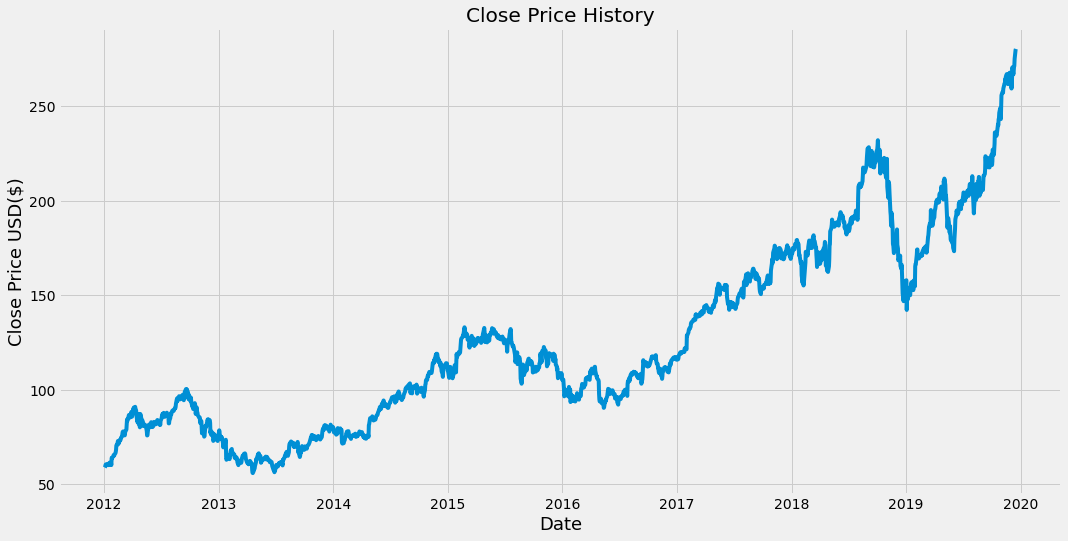

In [6]:
#visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.show()

In [7]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) * .8 )

training_data_len

1603

In [8]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01316509],
       [0.01457064],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

In [9]:
#Create the training data set

#Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range (60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<= 60:
    print(x_train)
    print(y_train)

[array([0.01316509, 0.01457064, 0.01748985, 0.02026915, 0.01984303,
       0.02080338, 0.02036454, 0.01962679, 0.01862193, 0.02173194,
       0.02453668, 0.02367172, 0.01893356, 0.02345548, 0.01900352,
       0.03569838, 0.03440731, 0.0360927 , 0.03973694, 0.04194384,
       0.0417594 , 0.0410789 , 0.04397903, 0.04670744, 0.04979839,
       0.05479095, 0.0652785 , 0.06543749, 0.07127594, 0.07563885,
       0.06814046, 0.07102789, 0.07097066, 0.07906688, 0.07791571,
       0.08004628, 0.08387497, 0.08600558, 0.09214292, 0.09661397,
       0.09790501, 0.09835659, 0.09071194, 0.08886753, 0.08914103,
       0.09632775, 0.09835024, 0.10269405, 0.11293358, 0.12659476,
       0.12403805, 0.1240444 , 0.13392141, 0.13701233, 0.13481179,
       0.13280207, 0.13070964, 0.13766105, 0.14243103, 0.14442805])]
[0.13949272033425864]


In [10]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1543, 60, 1)

In [12]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [13]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
#train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1543/1543 [==============================] - 33s 22ms/step - loss: 9.3842e-04


In [15]:
#Create the testing data set

#Create a nwe array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]

#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [16]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [17]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [18]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [19]:
#Get the root mean squared erro (RMSE)
rmse = np.sqrt( np.mean( predictions - y_test)**2 )
rmse

0.6389970779418945

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


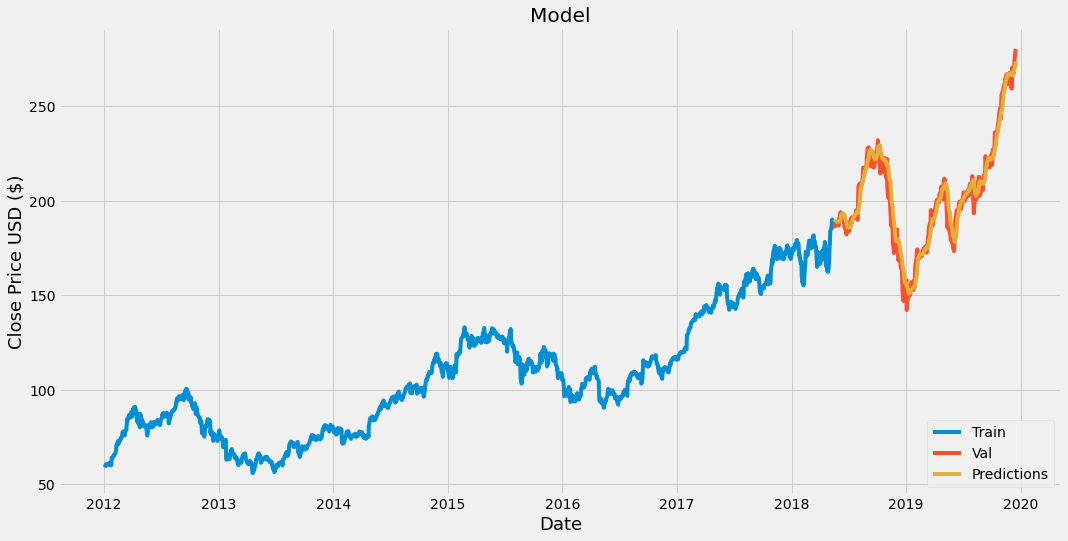

In [20]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train','Val', 'Predictions'], loc='lower right')
plt.show()

In [21]:
#Sho the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-05-17,186.990005,188.714020
2018-05-18,186.309998,189.018997
2018-05-21,187.630005,189.011429
2018-05-22,187.160004,188.982605
2018-05-23,188.360001,188.884003
...,...,...
2019-12-11,270.769989,268.453156
2019-12-12,271.459991,269.390076
2019-12-13,275.149994,270.414917


In [22]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

#Create a new dataframe
new_df = apple_quote.filter(['Close'])

#Get the last 60 dat closing price valvues and convert the dataframe to an array
last_60_days = new_df[-60:].values

#Scale the data to be calues between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

#Create an empty list
X_test = []

#Append the past 60 days
X_test.append(last_60_days_scaled)

#Convert the X_test data set to numpy array
X_test = np.array(X_test)

#Reshap the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Get the predicted scaled price
pred_price = model.predict(X_test)

#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[275.84344]]


In [23]:
#Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-12-18', end='2019-12-18')
print(apple_quote2['Close'])

Date
2019-12-18    279.73999
Name: Close, dtype: float64
